<a href="https://colab.research.google.com/github/Fidelisaboke/robust-nids/blob/feat%2Fbaseline-model/notebooks/02_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling the TII-SSRC-23 Dataset

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Libraries

In [2]:
!pip install fastparquet
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.2 MB/s eta 0:00:00


## Import Required Libraries

In [3]:
# Standard library for file/directory operations
import os

# Standard libraries for math and random generation
import math, random

# For showing progress
from tqdm import tqdm

# Collections library for specialized data structures
from collections import defaultdict, OrderedDict

# Data manipulation
import numpy as np
import pandas as pd

# For parquet file handling
import pyarrow.dataset as ds
import fastparquet

# Scikit-Learn
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Colors for plots
import colorsys

# For saving and loading models
import joblib

# Pretty print
from pprint import pprint


## Constants and Configuration

In [13]:
# Dataset path
CSV_PATH = '/content/drive/MyDrive/Datasets/TII-SSRC-23/data.csv'

# Parquet directory
PARQUET_DIR = 'parquet_files'

# Sampled data
OUT_PATH_CSV = '/content/drive/MyDrive/Datasets/TII-SSRC-23/sampled_200k.csv'
OUT_PATH_PARQUET = '/content/drive/MyDrive/Datasets/TII-SSRC-23/sampled_200k.parquet'

# Sample size
N_total = 200_000

# Chunk size
chunksize = 200_000

# Minimum to pick for every subtype
MIN_PER_SUBTYPE = 50

# Alpha - for square root weighting
ALPHA = 0.5

# Name for the target column
TARGET_COLUMN = "Label"

# Labels for benign/malicious
BENIGN_LABEL = "Benign"
MALICIOUS_LABEL = "Malicious"

# Type column
TYPE_COL = "Traffic Type"

# Subtype column
SUBTYPE_COL = "Traffic Subtype"

# Label Columns
LABEL_COLS = [TARGET_COLUMN, TYPE_COL, SUBTYPE_COL]

# Threshold and subset sie
LARGE_THRESHOLD = 50_000
CLUSTER_SUBSET_SIZE = 50_000

# Setting random and numpy seeds
random.seed(42)
np.random.seed(42)

## Converting Dataset to Parquet

In [6]:
os.makedirs(PARQUET_DIR, exist_ok=True)
for i, chunk in tqdm(enumerate(pd.read_csv(CSV_PATH, chunksize=chunksize))):
    fname = os.path.join(PARQUET_DIR, f"part_{i:05d}.parquet")
    chunk.to_parquet(fname, index=False, engine="fastparquet")

44it [03:12,  4.37s/it]


## Function for reading the Parquet

In [7]:
def parquet_chunk_reader(parquet_dir: str, batch_size: int, columns: list):
    """
    Yields Pandas DataFrames, each chunk of ~ batch_size rows, reading from
    a Parquet dataset (multiple files) using the pyarrow.dataset API.
    """
    dataset = ds.dataset(parquet_dir, format="parquet")
    scanner = dataset.scanner(columns=columns, batch_size=batch_size)
    for batch in scanner.to_batches():
        yield batch.to_pandas()

## Checking if Data was saved in parquet files

In [8]:
seen_subtypes = set()
for chunk in tqdm(parquet_chunk_reader(PARQUET_DIR, chunksize, columns=[SUBTYPE_COL])):
  seen_subtypes.update(chunk[SUBTYPE_COL].unique())
print("\nSubtypes actually in data:", seen_subtypes)

44it [00:01, 36.26it/s]


Subtypes actually in data: {'DoS RST', 'DoS ICMP', 'Video RTP', 'DoS ACK', 'Video UDP', 'Mirai Scan Bruteforce', 'Mirai DDoS UDP', 'DoS SYN', 'Mirai DDoS ACK', 'Mirai DDoS GREIP', 'Bruteforce FTP', 'Bruteforce SSH', 'Mirai DDoS SYN', 'DoS PSH', 'DoS FIN', 'Audio', 'DoS HTTP', 'DoS URG', 'Bruteforce Telnet', 'Mirai DDoS HTTP', 'Background', 'DoS UDP', 'DoS MAC', 'Information Gathering', 'Video HTTP', 'Mirai DDoS DNS', 'Bruteforce HTTP', 'Mirai DDoS GREETH', 'Text', 'DoS CWR', 'Bruteforce DNS', 'DoS ECN'}


## Setting Feature Columns

In [15]:
# Columns to remove
columns_to_remove = [
    'Flow ID',
    'Src IP',
    'Src Port',
    'Dst IP',
    'Dst Port',
    'Timestamp',
    'Label',
    'Traffic Type',
    'Traffic Subtype'
]
try:
    # Create a dataset object
    dataset = ds.dataset(PARQUET_DIR, format="parquet")

    # Get the column names from the schema
    all_columns = dataset.schema.names
except Exception as e:
    print(f"Error reading dataset schema: {e}")
    all_columns = []

# Convert both lists to sets for easy subtraction
all_columns_set = set(all_columns)
remove_set = set(columns_to_remove)

# Calculate the desired feature columns: All columns minus the ones to remove
FEATURE_COLS = sorted(list(all_columns_set - remove_set))

# Display feature columns neatly, line by line
print("Feature Columns:")
for i, feature_column in enumerate(FEATURE_COLS, start=1):
  print(f"{i}: {feature_column}")

Feature Columns:
1: ACK Flag Count
2: Active Max
3: Active Mean
4: Active Min
5: Active Std
6: Average Packet Size
7: Bwd Bulk Rate Avg
8: Bwd Bytes/Bulk Avg
9: Bwd Header Length
10: Bwd IAT Max
11: Bwd IAT Mean
12: Bwd IAT Min
13: Bwd IAT Std
14: Bwd IAT Total
15: Bwd Init Win Bytes
16: Bwd PSH Flags
17: Bwd Packet Length Max
18: Bwd Packet Length Mean
19: Bwd Packet Length Min
20: Bwd Packet Length Std
21: Bwd Packet/Bulk Avg
22: Bwd Packets/s
23: Bwd Segment Size Avg
24: Bwd URG Flags
25: CWR Flag Count
26: Down/Up Ratio
27: ECE Flag Count
28: FIN Flag Count
29: FWD Init Win Bytes
30: Flow Bytes/s
31: Flow Duration
32: Flow IAT Max
33: Flow IAT Mean
34: Flow IAT Min
35: Flow IAT Std
36: Flow Packets/s
37: Fwd Act Data Pkts
38: Fwd Bulk Rate Avg
39: Fwd Bytes/Bulk Avg
40: Fwd Header Length
41: Fwd IAT Max
42: Fwd IAT Mean
43: Fwd IAT Min
44: Fwd IAT Std
45: Fwd IAT Total
46: Fwd PSH Flags
47: Fwd Packet Length Max
48: Fwd Packet Length Mean
49: Fwd Packet Length Min
50: Fwd Packet Le

## Sampling Process
### 1. Compute counts per label, traffic type, and traffic subtype

In [16]:
# Dicts for counts
label_counts = defaultdict(int)
type_counts = defaultdict(int)
subtype_counts = defaultdict(int)
total_rows = 0
count_cols = [TARGET_COLUMN, "Traffic Type", "Traffic Subtype"]

for chunk in tqdm(parquet_chunk_reader(PARQUET_DIR, chunksize, columns=count_cols)):
  total_rows += len(chunk)

  # Label value counts
  vc_label = chunk[TARGET_COLUMN].value_counts()
  for lbl, c in vc_label.items():
    label_counts[lbl] += c

  # Traffic type counts
  vc_type = chunk["Traffic Type"].value_counts()
  for lbl, c in vc_type.items():
    type_counts[lbl] += c

  # Traffic subtype counts
  vc_sub = chunk["Traffic Subtype"].value_counts()
  for lbl, c in vc_sub.items():
    subtype_counts[lbl] += c


print("\nTotal rows (approx):", total_rows)
print("Label counts:", dict(list(label_counts.items())))
print("Traffic type counts:", dict(list(type_counts.items())))

44it [00:03, 13.84it/s]


Total rows (approx): 8656767
Label counts: {'Malicious': 8655466, 'Benign': 1301}
Traffic type counts: {'DoS': 7490929, 'Bruteforce': 35172, 'Audio': 190, 'Background': 32, 'Information Gathering': 1038363, 'Mirai': 91002, 'Video': 870, 'Text': 209}


### Distribtion of label counts, traffic types, and traffic subtypes



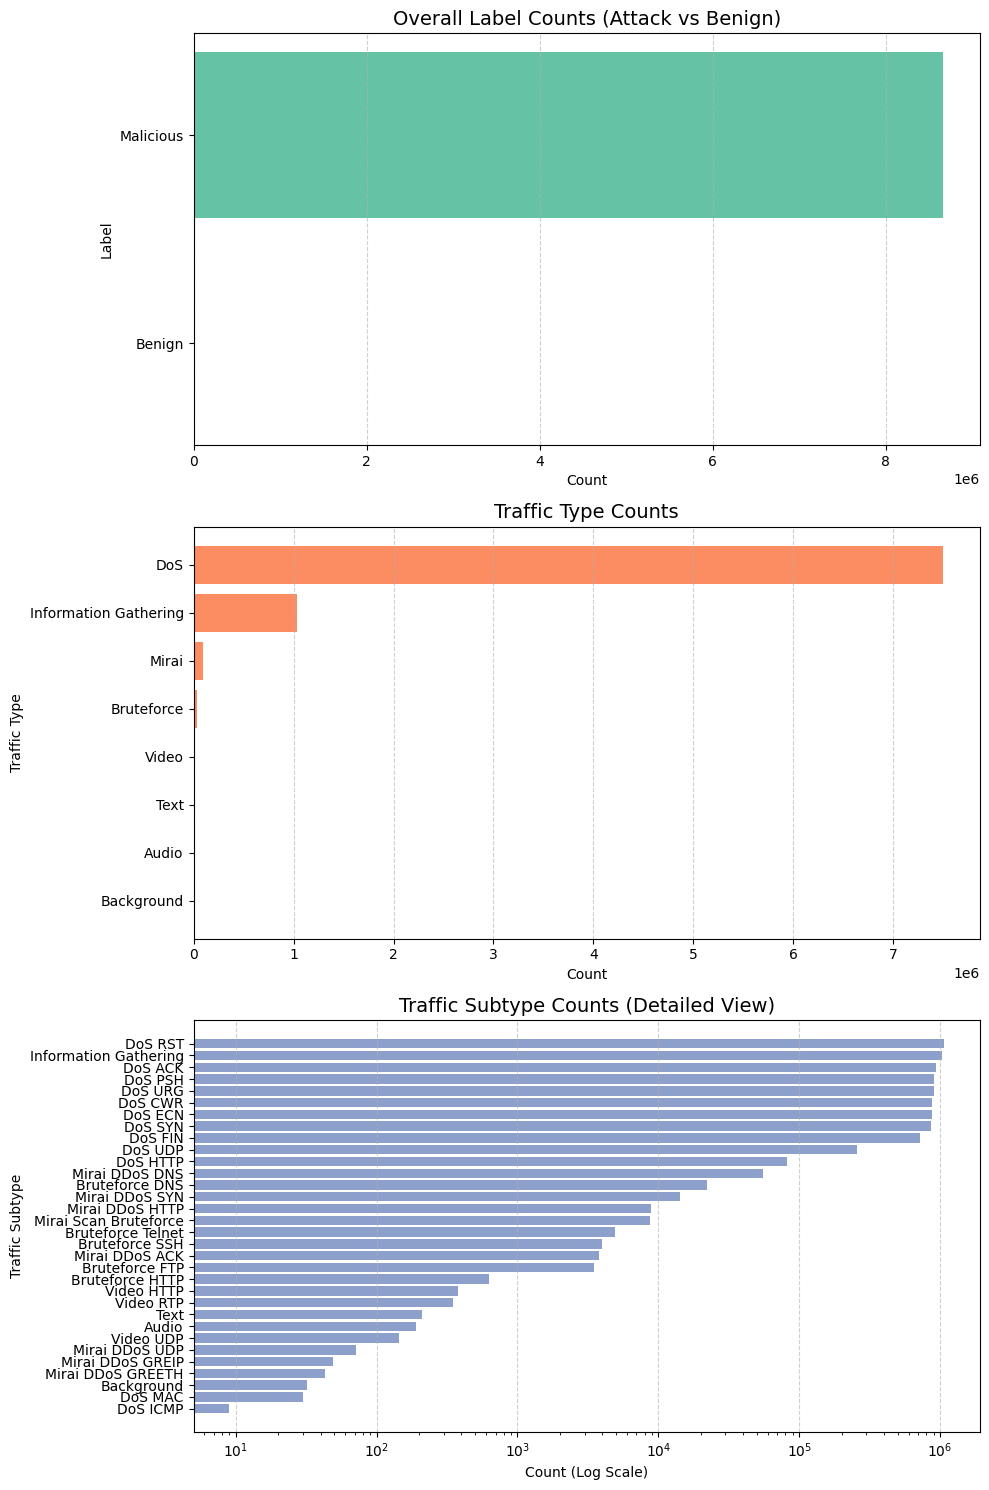

In [17]:
count_data = [
    (label_counts, "Label", "Overall Label Counts (Attack vs Benign)"),
    (type_counts, "Traffic Type", "Traffic Type Counts"),
    (subtype_counts, "Traffic Subtype", "Traffic Subtype Counts (Detailed View)")
]

# Subplotting
fig, axes = plt.subplots(len(count_data), 1, figsize=(10, 5 * len(count_data)))
plt.subplots_adjust(hspace=0.5)

for i, (counts_dict, title_prefix, plot_title) in enumerate(count_data):
    counts_series = pd.Series(counts_dict).sort_values(ascending=True)
    ax = axes[i]

    # Logarithmic scale
    if title_prefix == "Traffic Subtype" and counts_series.max() / counts_series.min() > 100:
        x_scale = 'log'
        x_label = 'Count (Log Scale)'
    else:
        x_scale = 'linear'
        x_label = 'Count'

    # Horizontal bar chart
    ax.barh(counts_series.index, counts_series.values, color=plt.cm.Set2(i))
    ax.set_title(plot_title, fontsize=14)
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel(title_prefix, fontsize=10)
    ax.set_xscale(x_scale)
    ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

From the first pass, the following can be noted:
1. It takes roughly 3 minutes to process the CSV dataset:
- This necessitates the need to pick a subset of the data, as loading the entire dataset takes a lot of time
- The parquet files, however, cut down the dataset loading time
2. There's a huge imbalance between benign and malicious:
- This suggests retrieving all benign records as there's only 1301
- DoS records dominate the dataset, compared to other traffic types

## 2. Determining allocation

### Step 1: Allocate sample sizes to each subtype

In [18]:
# Allocations for every subtype
alloc_subtype = {
  # Benign
  "Audio": 190,
  "Background": 32,
  "Video HTTP": 376,
  "Video RTP": 349,
  "Video UDP": 145,
  "Text": 209,

  # Malicious / DoS subtypes
  "DoS RST": 11000,
  "DoS ACK": 9000,
  "DoS PSH": 9000,
  "DoS URG": 9000,
  "DoS CWR": 8500,
  "DoS ECN": 8500,
  "DoS SYN": 9000,
  "DoS FIN": 8000,
  "DoS HTTP": 2000,
  "DoS UDP": 3000,
  "DoS ICMP": 9,
  "DoS MAC": 30,

  # Malicious / Bruteforce
  "Bruteforce DNS": 500,
  "Bruteforce Telnet": 200,
  "Bruteforce SSH": 200,
  "Bruteforce FTP": 200,
  "Bruteforce HTTP": 50,

  # Malicious / Information Gathering
  "Information Gathering": 10000,

  # Malicious / Mirai
  "Mirai DDoS DNS": 1000,
  "Mirai DDoS SYN": 500,
  "Mirai DDoS HTTP": 500,
  "Mirai DDoS ACK": 200,
  "Mirai Scan Bruteforce": 300,
  "Mirai DDoS UDP": 50,
  "Mirai DDoS GREIP": 20,
  "Mirai DDoS GREETH": 20
}

- All benign records are to be included
- The remaining slots are for malicious samples

In [19]:
# benign_subtypes
benign_subtypes_list = [
    "Audio",
    "Background",
    "Video HTTP",
    "Video RTP",
    "Video UDP",
    "Text"
]

benign_subtypes = [s for s,c in subtype_counts.items() if s in benign_subtypes_list]
benign_total = sum([subtype_counts[s] for s in benign_subtypes])

# Total number of allocations left for malicious samples
mal_budget = N_total - benign_total

print("Benign subtypes:", benign_subtypes)
print("Benign total:", benign_total)
print("Malicious budget:", mal_budget)

Benign subtypes: ['Audio', 'Background', 'Video HTTP', 'Video RTP', 'Text', 'Video UDP']
Benign total: 1301
Malicious budget: 198699


### Step 2: Deciding per-subtype budgets using temered proportional (sqrt)
This step is based off of an estimated sample size ($n_i$), calculated using the following formula:

$$
n_i = \lfloor \frac{Ni^\alpha}{W} \times S_{malicious} \rfloor
$$

In [20]:
alpha = ALPHA

mal_subtypes = [s for s in subtype_counts if s not in benign_subtypes]
weights = {s: (subtype_counts[s]**alpha) for s in mal_subtypes}
W = sum(weights.values())

# Allocation
for s in mal_subtypes:
  n = max(MIN_PER_SUBTYPE, int(round(weights[s] / W * mal_budget)))
  n = min(n, subtype_counts[s])
  alloc_subtype[s] = n

# Totals should match N_total
current_total = sum(alloc_subtype.values()) + benign_total
delta = N_total - current_total

if delta > 0:
    # add 1 to top - pop subtypes until delta exhausted
    sorted_pop = sorted(mal_subtypes, key=lambda x: -subtype_counts[x])
    i = 0
    while delta > 0:
        s = sorted_pop[i % len(sorted_pop)]
        if alloc_subtype[s] < subtype_counts[s]:
            alloc_subtype[s] += 1
            delta -= 1
        i += 1

elif delta < 0:
    sorted_alloc = sorted(alloc_subtype.items(), key=lambda x: -x[1])
    i = 0
    while delta<0:
        s,_ = sorted_alloc[i % len(sorted_alloc)]
        if alloc_subtype[s] > MIN_PER_SUBTYPE:
            alloc_subtype[s] -= 1
            delta += 1
        i += 1

# Add benign to subtype allocations
for s in benign_subtypes:
    alloc_subtype[s] = subtype_counts[s]

print("Total allocations:", sum(alloc_subtype.values()))

Total allocations: 198869


### Allocation Results

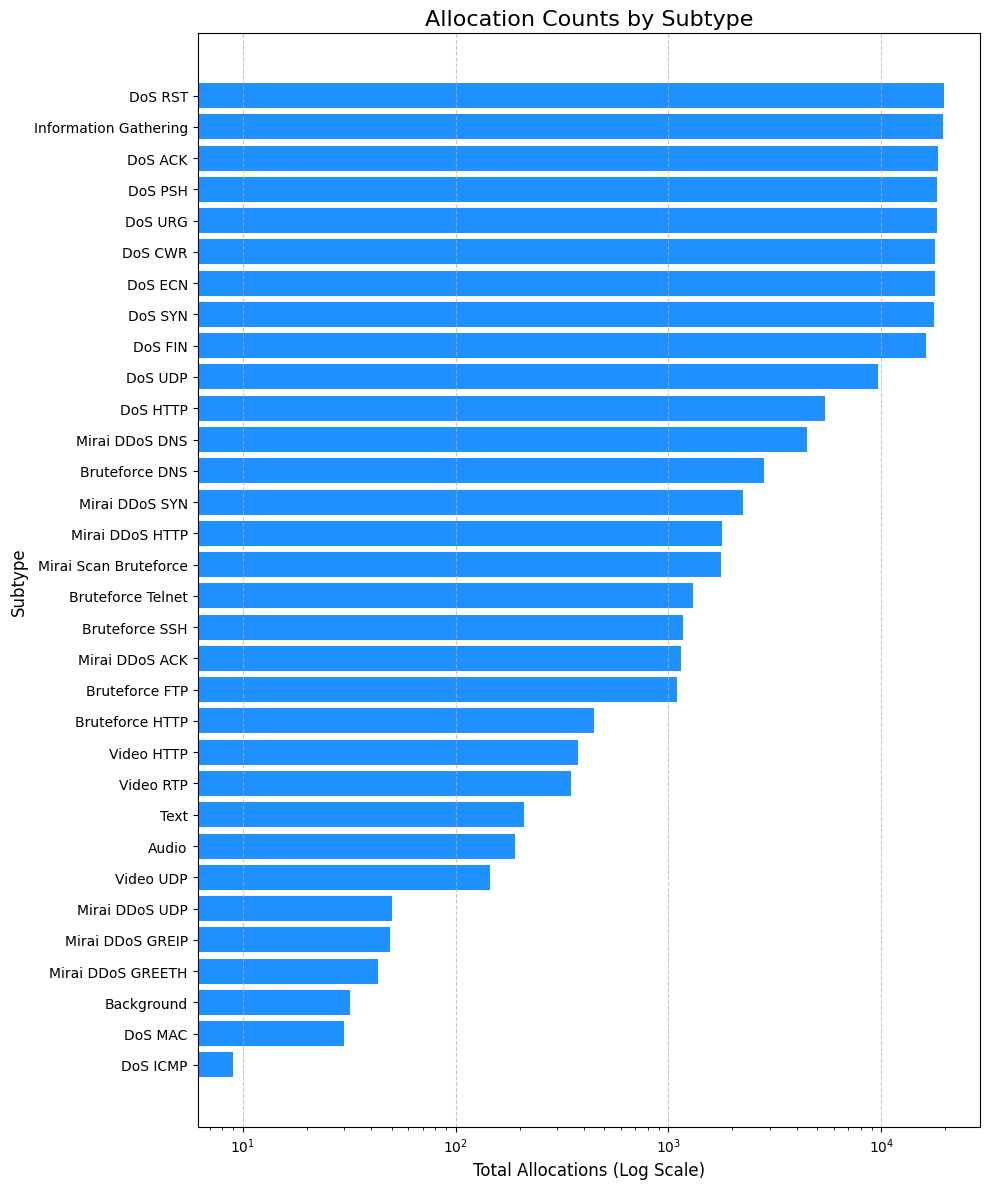

In [21]:
alloc_data = pd.Series(alloc_subtype, name='Count')
alloc_df = alloc_data.reset_index().rename(columns={'index': 'Subtype'})
df_sorted = alloc_df.sort_values(by='Count', ascending=True)

# Horizontal bar chart showing allocation types in descending order
plt.figure(figsize=(10, 12))
plt.barh(df_sorted['Subtype'], df_sorted['Count'], color='dodgerblue')
plt.title('Allocation Counts by Subtype', fontsize=16)
plt.xlabel('Total Allocations (Log Scale)', fontsize=12)
plt.ylabel('Subtype', fontsize=12)

# Log scale - To better visualize the types
plt.xscale('log')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

### Step 3: Cluster large subtypes

In [22]:
# Feature cols to use
feature_cols = FEATURE_COLS

cluster_models = {}
cluster_info = {}  # maps subtype -> {k, cluster_sizes}


for s in tqdm(mal_subtypes):
    N = subtype_counts[s]
    if N <= LARGE_THRESHOLD:
        continue

    # Gather a random subset for clustering
    subset_rows = []
    needed = min(CLUSTER_SUBSET_SIZE, N)
    seen = 0

    for chunk in parquet_chunk_reader(
        parquet_dir=PARQUET_DIR,
        batch_size=chunksize,
        columns=feature_cols + LABEL_COLS
    ):
        seen += len(chunk)
        # Filter to subtype
        csub = chunk[chunk[SUBTYPE_COL]==s]
        if len(csub)==0:
            continue

        # Sample some proportionally
        take = min(len(csub), needed - len(subset_rows))
        subset_rows.append(csub.sample(n=take) if len(csub)>take else csub)
        if len(subset_rows) >= needed:
            break

    if not subset_rows:
        continue

    df_sub = pd.concat(subset_rows, ignore_index=True)
    X = df_sub[feature_cols].fillna(0).values
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    pca = PCA(n_components=min(16, Xs.shape[1])).fit(Xs)
    Xp = pca.transform(Xs)

    # Choose k
    k = min(max(5, int(math.sqrt(N/1000))), 40)
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048)
    mbk.fit(Xp)
    labels = mbk.predict(Xp)

    # Compute metrics for valid clusters
    sil = None; db = None; ch = None
    if k > 1:
        # If data is large, subsample
        max_samples = 10000
        n = Xp.shape[0]
        if n > max_samples:
            # Randomly pick subset indices
            idx = np.random.choice(n, size=max_samples, replace=False)
            Xp_sub = Xp[idx]
            labels_sub = labels[idx]
        else:
            Xp_sub = Xp
            labels_sub = labels

        try:
            sil = silhouette_score(Xp_sub, labels_sub)
            db = davies_bouldin_score(Xp_sub, labels_sub)
            ch = calinski_harabasz_score(Xp_sub, labels_sub)
        except Exception as e:
            print(f"Cannot compute metrics for subtype {s} (k={k}): {e}")
            continue

    counts = {int(i): int(np.sum(labels==i)) for i in range(k)}

    # Save cluster models and information
    cluster_models[s] = (scaler, pca, mbk)
    cluster_info[s] = {
        "k": k,
        "cluster_counts": counts,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch
    }

# Cluster models
print("\nCluster models:")
pprint(cluster_models)

100%|██████████| 26/26 [03:21<00:00,  7.76s/it]


Cluster models:
{'DoS ACK': (StandardScaler(),
             PCA(n_components=16),
             MiniBatchKMeans(batch_size=2048, n_clusters=30, random_state=42)),
 'DoS CWR': (StandardScaler(),
             PCA(n_components=16),
             MiniBatchKMeans(batch_size=2048, n_clusters=29, random_state=42)),
 'DoS ECN': (StandardScaler(),
             PCA(n_components=16),
             MiniBatchKMeans(batch_size=2048, n_clusters=29, random_state=42)),
 'DoS FIN': (StandardScaler(),
             PCA(n_components=16),
             MiniBatchKMeans(batch_size=2048, n_clusters=26, random_state=42)),
 'DoS HTTP': (StandardScaler(),
              PCA(n_components=16),
              MiniBatchKMeans(batch_size=2048, n_clusters=9, random_state=42)),
 'DoS PSH': (StandardScaler(),
             PCA(n_components=16),
             MiniBatchKMeans(batch_size=2048, n_clusters=30, random_state=42)),
 'DoS RST': (StandardScaler(),
             PCA(n_components=16),
             MiniBatchKMeans(batch_size

### Plotting the metrics

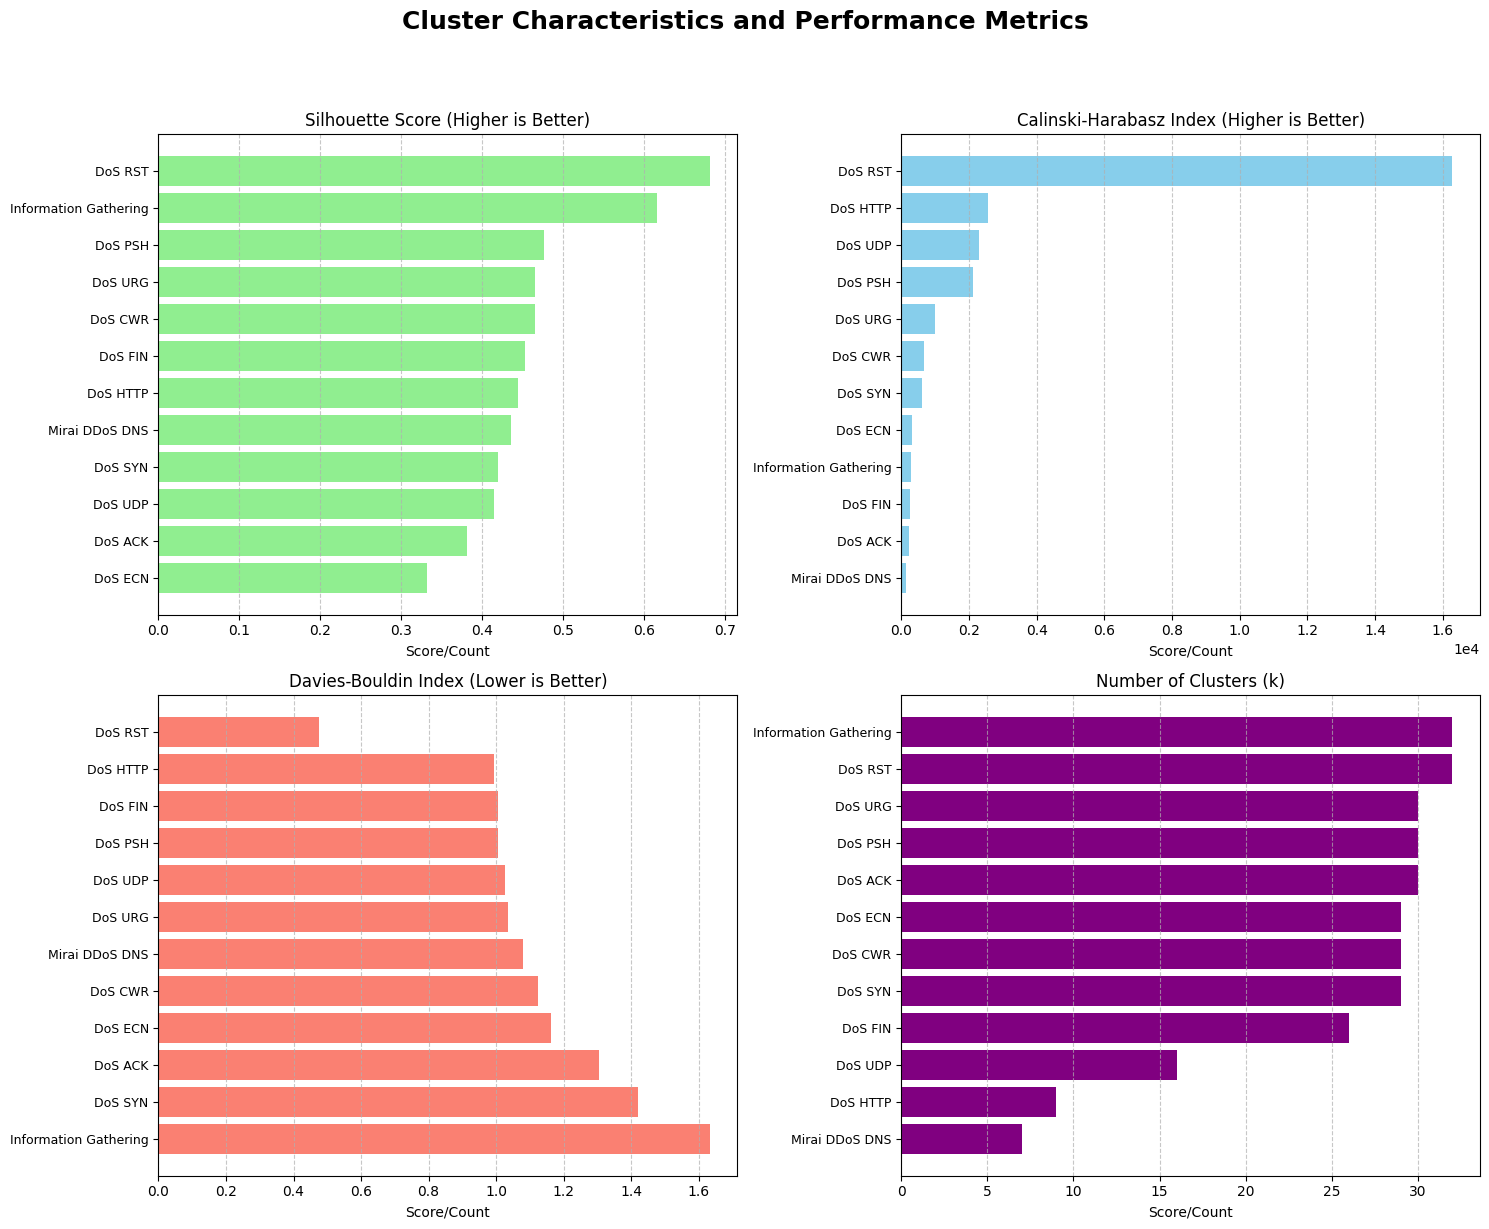

In [23]:
# Metrics and their visualization properties
metrics_plot_data = OrderedDict([
    ('Silhouette', {'color': 'lightgreen', 'title': 'Silhouette Score (Higher is Better)', 'sort_asc': True}),
    ('Calinski-Harabasz', {'color': 'skyblue', 'title': 'Calinski-Harabasz Index (Higher is Better)', 'sort_asc': True}),
    ('Davies-Bouldin', {'color': 'salmon', 'title': 'Davies-Bouldin Index (Lower is Better)', 'sort_asc': False}),
    ('k', {'color': 'purple', 'title': 'Number of Clusters (k)', 'sort_asc': True}),
])

# Data lists
cluster_plot_data = {name: [] for name in metrics_plot_data.keys()}
labels = []

for model, metrics_data in cluster_info.items():
    labels.append(model)
    cluster_plot_data['Silhouette'].append(metrics_data['silhouette'])
    cluster_plot_data['Calinski-Harabasz'].append(metrics_data['calinski_harabasz'])
    cluster_plot_data['Davies-Bouldin'].append(metrics_data['davies_bouldin'])
    cluster_plot_data['k'].append(metrics_data['k'])

# Creating subplots for all four items
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax = ax.flatten()  # Flattens the 2x2 array of axes for easy indexing

plt.suptitle('Cluster Characteristics and Performance Metrics', fontsize=18, fontweight='bold', y=1.02)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, (metric_name, props) in enumerate(metrics_plot_data.items()):
    values = cluster_plot_data[metric_name]

    # Temporary DataFrame to sort the bars
    df_temp = pd.DataFrame({'labels': labels, 'values': values})
    df_temp = df_temp.sort_values(by='values', ascending=props['sort_asc'])

    # Sorted horizontal bar chart
    ax[i].barh(df_temp['labels'], df_temp['values'], color=props['color'])
    ax[i].set_title(props['title'], fontsize=12)
    ax[i].set_xlabel('Score/Count', fontsize=10)
    ax[i].tick_params(axis='y', labelsize=9)
    ax[i].grid(axis='x', linestyle='--', alpha=0.7)

    # Format for large numbers (Calinski-Harabasz)
    if metric_name == 'Calinski-Harabasz':
        ax[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


### Save cluster models

In [27]:
# Save cluster_models to disk for use in streaming pass
joblib.dump(cluster_models, '/content/cluster_models.joblib')

['/content/cluster_models.joblib']

## Step 4: Compute per (subtype, cluster) quota

In [24]:
alloc_cell = {}   # (subtype, cluster or '_no_cluster') -> quota
for s, n_sub in alloc_subtype.items():
    if s in cluster_info:
        counts = cluster_info[s]["cluster_counts"]
        # Weight per cluster = sqrt(cluster_size)
        Wc = sum((c**alpha) for c in counts.values())
        for ci, csize in counts.items():
            q = max(1, int(round((csize**alpha / Wc) * n_sub)))
            alloc_cell[(s, ci)] = min(q, csize)
    else:
        alloc_cell[(s, "_no_cluster")] = n_sub

# Adjust cell sums to exactly match alloc_subtype per subtype (distribute residuals)
for s in alloc_subtype:
    # Sum current cells for this subtype
    keys = [k for k in alloc_cell if k[0]==s]
    ssum = sum(alloc_cell[k] for k in keys)
    diff = alloc_subtype[s] - ssum
    if diff>0:
        # Add to largest cluster(s)
        keys_sorted = sorted(keys, key=lambda k: (cluster_info.get(s,{}).get("cluster_counts",{}).get(k[1], alloc_subtype[s])), reverse=True)
        i=0
        while diff>0:
            alloc_cell[keys_sorted[i % len(keys_sorted)]] += 1
            diff -= 1
            i+=1
    elif diff<0:
        # Subtract from largest allocations
        keys_sorted = sorted(keys, key=lambda k: alloc_cell[k], reverse=True)
        i=0
        while diff<0:
            if alloc_cell[keys_sorted[i % len(keys_sorted)]]>1:
                alloc_cell[keys_sorted[i % len(keys_sorted)]] -= 1
                diff += 1
            i+=1

### Visualization of per (subtype, cluster) quota

<Figure size 1500x1000 with 0 Axes>

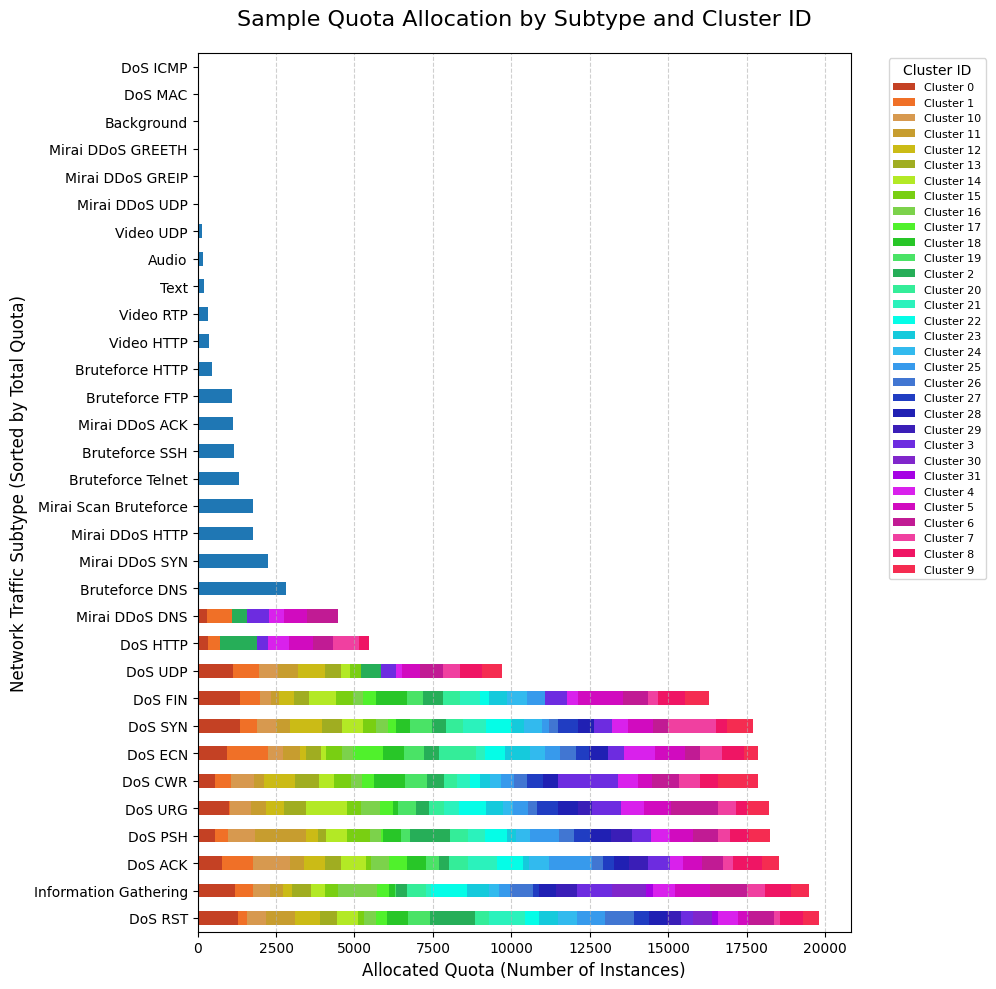

In [25]:
alloc_df = pd.DataFrame(
    list(alloc_cell.items()),
    columns=['Key', 'Quota']
)
alloc_df[['Subtype', 'Cluster_ID']] = pd.DataFrame(
    alloc_df['Key'].tolist(), index=alloc_df.index
)
alloc_df.drop('Key', axis=1, inplace=True)

# Convert Cluster_ID to string for visualization (including integers and '_no_cluster')
alloc_df['Cluster_ID'] = alloc_df['Cluster_ID'].astype(str)

# Pivot table where rows are subtypes and columns are cluster IDs
df_pivot = alloc_df.pivot_table(
    index='Subtype',
    columns='Cluster_ID',
    values='Quota',
    fill_value=0
)

# Calculate total quota per subtype and sort the index
df_pivot['Total'] = df_pivot.sum(axis=1)
df_pivot = df_pivot.sort_values(by='Total', ascending=False)
df_pivot.drop('Total', axis=1, inplace=True)

# Ensure '_no_cluster' is the first column for coloring consistency
if '_no_cluster' in df_pivot.columns:
    cols = ['_no_cluster'] + [col for col in df_pivot.columns if col != '_no_cluster']
    df_pivot = df_pivot[cols]

# Generate a large number of distinct colors
def get_colors(num_colors):
    # Generate random HLS colors and convert to hex for distinctness
    colors = []
    for i in range(num_colors):
        h = i / num_colors
        l = 0.4 + (random.random() * 0.2)  # Lightness between 0.4 and 0.6
        s = 0.6 + (random.random() * 0.4)  # Saturation between 0.6 and 1.0
        r, g, b = [int(x * 255) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')
    return colors

# Generate colors, ensuring a specific color for '_no_cluster'
cluster_ids = df_pivot.columns.tolist()
num_colors = len(cluster_ids)
colors = get_colors(num_colors)
color_map = {cid: colors[i] for i, cid in enumerate(cluster_ids)}

# Set a distinct, static color for non-clustered data
if '_no_cluster' in color_map:
    color_map['_no_cluster'] = '#1f77b4' # Muted blue for non-clustered

# Plotting the Stacked Bar Chart
plt.figure(figsize=(15, 10))

# Plot the transposed DataFrame (Subtypes are on the y-axis)
# The `color_map` ensures that the same cluster ID always has the same color across different bars
df_pivot.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 10),
    color=[color_map[cid] for cid in df_pivot.columns]
)

plt.title('Sample Quota Allocation by Subtype and Cluster ID', fontsize=16, pad=20)
plt.xlabel('Allocated Quota (Number of Instances)', fontsize=12)
plt.ylabel('Network Traffic Subtype (Sorted by Total Quota)', fontsize=12)

# Legend adjustment: Legend outside the plot area
# Proxy legend handle for the special case
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [f"Cluster {l}" if l != '_no_cluster' else "Not Clustered" for l in labels]

plt.legend(
    handles,
    new_labels,
    title='Cluster ID',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=8
)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## Step 4: Streaming Pass - Reservior per cell
- Reservoir sampling is applied here to obtain the final samples

In [28]:
# Reservoir buffers and counters
reservoirs = {cell: [] for cell in alloc_cell}
seen_per_cell = {cell: 0 for cell in alloc_cell}

cluster_models = joblib.load('/content/cluster_models.joblib')

target_cols = LABEL_COLS

for chunk in tqdm(parquet_chunk_reader(PARQUET_DIR, chunksize, columns=feature_cols + target_cols)):
    df = chunk

    # Process subtypes that have clustering models
    for s, (scaler, pca, mbk) in cluster_models.items():
        # Select rows of this subtype
        mask = (df[SUBTYPE_COL] == s)
        if not mask.any():
            continue

        # Extract feature matrix, convert, fill
        sub_df = df.loc[mask, feature_cols + target_cols]
        # Convert to float and fill missing
        X = sub_df[feature_cols].astype(float).fillna(0).values  # shape (n_s, num_features)

        # Transform via scaler and PCA
        Xs = scaler.transform(X)
        Xp = pca.transform(Xs)

        # Predict cluster IDs
        cluster_ids = mbk.predict(Xp)  # array length n_s

        # Process each cluster in this subtype in bulk
        unique_cids = np.unique(cluster_ids)
        for ci in unique_cids:
            # Indices where that cluster id appears
            idxs = np.where(cluster_ids == ci)[0]
            if idxs.size == 0:
                continue

            cell = (s, int(ci))
            if cell not in alloc_cell:
                # Skip unexpected cell
                continue
            k = alloc_cell[cell]

            # How many rows seen now for that cell
            for local_idx in idxs:
                seen_per_cell[cell] += 1
                seen = seen_per_cell[cell]
                row = sub_df.iloc[local_idx]
                if len(reservoirs[cell]) < k:
                    reservoirs[cell].append(row.to_dict())
                else:
                    j = random.randint(1, seen)
                    if j <= k:
                        replace_idx = random.randint(0, k - 1)
                        reservoirs[cell][replace_idx] = row.to_dict()

    # Process subtypes without clustering (i.e. "_no_cluster")
    no_cluster_subtypes = [s for s in alloc_subtype if s not in cluster_models]
    for s in no_cluster_subtypes:
        mask2 = (df[SUBTYPE_COL] == s)
        if not mask2.any():
            continue
        sub_df2 = df.loc[mask2]  # DataFrame
        cell = (s, "_no_cluster")
        if cell not in alloc_cell:
            continue
        k = alloc_cell[cell]

        # Simulate reservoir for these rows
        for _, row in sub_df2.iterrows():
            seen_per_cell[cell] += 1
            seen = seen_per_cell[cell]
            if len(reservoirs[cell]) < k:
                reservoirs[cell].append(row.to_dict())
            else:
                j = random.randint(1, seen)
                if j <= k:
                    replace_idx = random.randint(0, k - 1)
                    reservoirs[cell][replace_idx] = row.to_dict()

# Reservoir sizes vs quotas
print()
for cell, quota in alloc_cell.items():
    print(cell, "quota:", quota, "samples:", len(reservoirs[cell]))


44it [14:13, 19.40s/it]


('Audio', '_no_cluster') quota: 190 samples: 190
('Background', '_no_cluster') quota: 32 samples: 32
('Video HTTP', '_no_cluster') quota: 376 samples: 376
('Video RTP', '_no_cluster') quota: 349 samples: 349
('Video UDP', '_no_cluster') quota: 145 samples: 145
('Text', '_no_cluster') quota: 209 samples: 209
('DoS RST', 0) quota: 1283 samples: 1283
('DoS RST', 1) quota: 281 samples: 281
('DoS RST', 2) quota: 1433 samples: 1433
('DoS RST', 3) quota: 393 samples: 393
('DoS RST', 4) quota: 627 samples: 627
('DoS RST', 5) quota: 337 samples: 337
('DoS RST', 6) quota: 794 samples: 794
('DoS RST', 7) quota: 200 samples: 200
('DoS RST', 8) quota: 734 samples: 734
('DoS RST', 9) quota: 526 samples: 526
('DoS RST', 10) quota: 621 samples: 621
('DoS RST', 11) quota: 932 samples: 932
('DoS RST', 12) quota: 792 samples: 792
('DoS RST', 13) quota: 521 samples: 521
('DoS RST', 14) quota: 676 samples: 676
('DoS RST', 15) quota: 187 samples: 187
('DoS RST', 16) quota: 396 samples: 396
('DoS RST', 17) 

### Reservoir visualizations

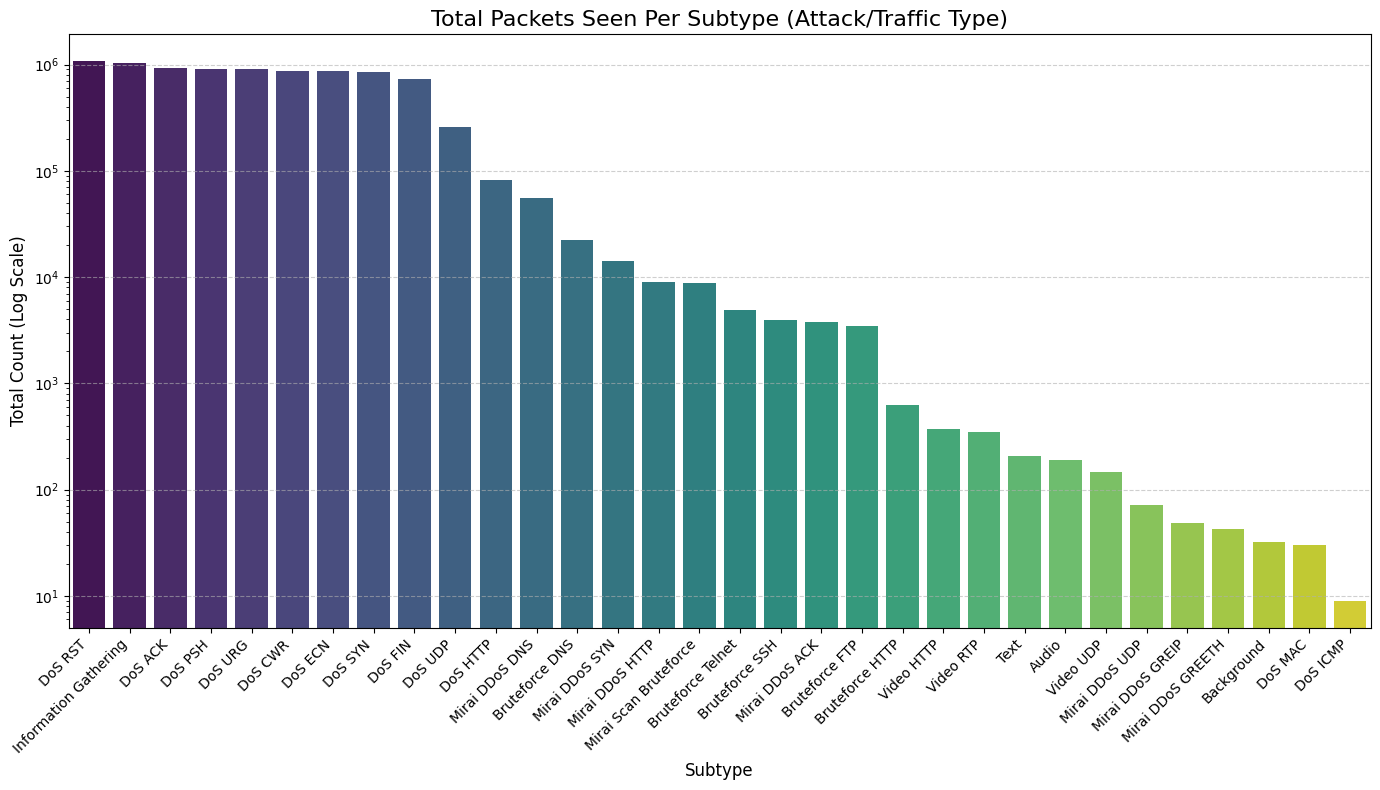

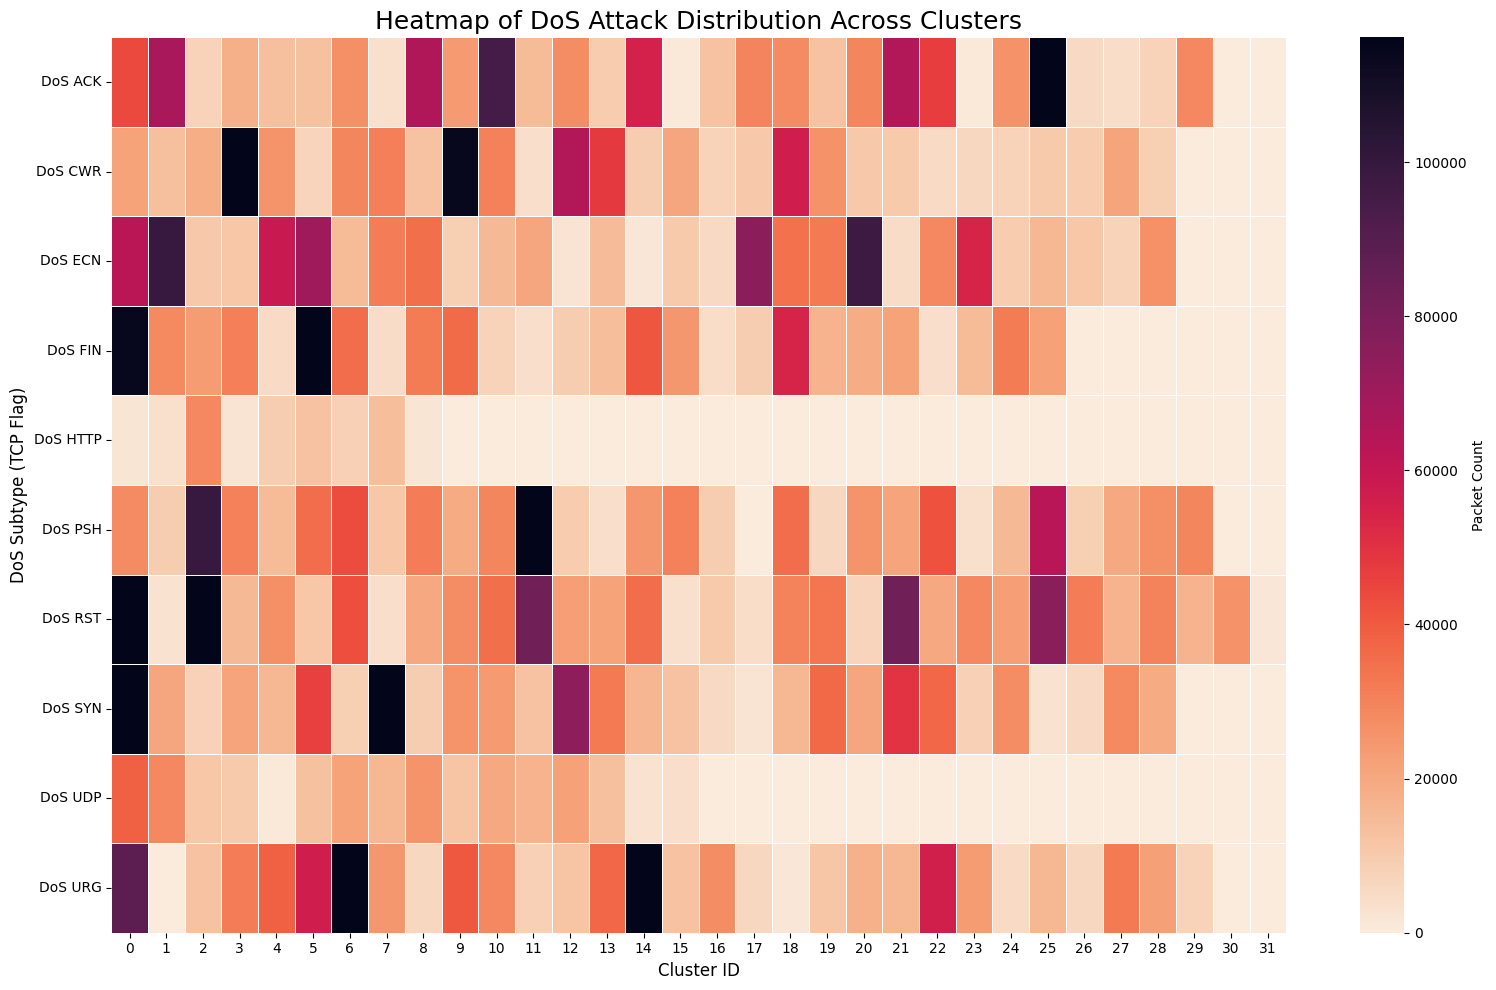

In [29]:
reservoir_df = pd.DataFrame(
    [(subtype, cluster, count) for (subtype, cluster), count in seen_per_cell.items()],
    columns=['Subtype', 'Cluster_ID', 'Count']
)

# Convert Cluster_ID to string for plotting purposes
reservoir_df['Cluster_ID'] = reservoir_df['Cluster_ID'].astype(str)

# Extract the main category for grouping, e.g., 'DoS RST' -> 'DoS'
def extract_main_category(subtype):
  """
  Extract the main category for grouping.
  e.g., 'DoS RST' -> 'DoS'
  """
  if subtype.startswith('DoS'):
      return 'DoS'
  elif subtype.startswith('Mirai'):
      return 'Mirai'
  elif subtype.startswith('Bruteforce'):
      return 'Bruteforce'
  elif subtype.startswith('Video'):
      return 'Video'
  return subtype

reservoir_df['Main_Category'] = reservoir_df['Subtype'].apply(extract_main_category)

# Aggregate counts by the full Subtype (e.g., 'DoS RST', 'Information Gathering')
total_counts = reservoir_df.groupby('Subtype')['Count'].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=total_counts.index, y=total_counts.values, hue=total_counts.index, palette="viridis", legend=False)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.title('Total Packets Seen Per Subtype (Attack/Traffic Type)', fontsize=16)
plt.xlabel('Subtype', fontsize=12)
plt.ylabel('Total Count (Log Scale)', fontsize=12)
plt.yscale('log') # Use log scale due to huge variation in counts
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Filter for all DoS subtypes
dos_df = reservoir_df[reservoir_df['Main_Category'] == 'DoS'].copy()

# Filter out the small number of DoS with '_no_cluster' for a clean cluster heatmap
dos_df = dos_df[dos_df['Cluster_ID'] != '_no_cluster']

# Convert Cluster_ID back to numeric for correct sorting in the heatmap axes
dos_df['Cluster_ID'] = dos_df['Cluster_ID'].astype(int)

# Create a pivot table for the heatmap
heatmap_data = dos_df.pivot_table(
    index='Subtype',
    columns='Cluster_ID',
    values='Count',
    fill_value=0 # Fill missing (Subtype, Cluster) pairs with 0
).sort_index(ascending=True) # Sort subtypes alphabetically for consistency

# Ensure Cluster IDs are fully represented from 0 up to max ID for visual consistency
max_cluster = heatmap_data.columns.max()
all_clusters = range(max_cluster + 1)
# Reindex the columns to include all possible cluster IDs
heatmap_data = heatmap_data.reindex(columns=all_clusters, fill_value=0)


plt.figure(figsize=(16, 10))
# Plot heatmap using 'rocket' palette for high contrast
sns.heatmap(
    heatmap_data,
    cmap='rocket_r',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Packet Count'},
    norm=plt.Normalize(vmax=heatmap_data.max().max() * 0.5) # Normalize scale for better contrast of lower values
)
plt.title('Heatmap of DoS Attack Distribution Across Clusters', fontsize=18)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('DoS Subtype (TCP Flag)', fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Save the sample

- Function for saving the sample

In [30]:
def save_reservoir_sample(
    reservoirs,
    alloc_cell,
    out_path_csv="sampled.csv",
    out_path_parquet="sampled.parquet",
    save_csv=True,
    save_parquet=True,
    engine="pyarrow"
):
    """
    Save the reservoir sample to CSV and/or Parquet.
    Adds columns _subtype and _cluster for provenance.
    """
    rows = []
    for (subtype, cluster), row_dicts in reservoirs.items():
        for rd in row_dicts:
            rd2 = rd.copy()
            rd2["_subtype"] = subtype
            rd2["_cluster"] = cluster
            rows.append(rd2)

    df = pd.DataFrame(rows)
    print("Sample DataFrame size:", df.shape)

    try:
        df["_cluster"] = df["_cluster"].astype("int64")
    except ValueError:
        df["_cluster"] = df["_cluster"].astype(str)

    # Save CSV
    if save_csv:
        df.to_csv(out_path_csv, index=False)
        print("Saved CSV to", out_path_csv)

    # Save Parquet
    if save_parquet:
        df.to_parquet(out_path_parquet, index=False, engine=engine)
        print("Saved Parquet to", out_path_parquet)

    return df



### Saving data to Google Drive

In [31]:
df_sample = save_reservoir_sample(
    reservoirs,
    alloc_cell,
    out_path_csv=OUT_PATH_CSV,
    out_path_parquet=OUT_PATH_PARQUET
)
df_sample.head()

Sample DataFrame size: (198869, 82)
Saved CSV to /content/drive/MyDrive/Datasets/TII-SSRC-23/sampled_200k.csv
Saved Parquet to /content/drive/MyDrive/Datasets/TII-SSRC-23/sampled_200k.parquet


,ACK Flag Count,Active Max,Active Mean,Active Min,Active Std,Average Packet Size,Bwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Header Length,Bwd IAT Max,Bwd IAT Mean,Bwd IAT Min,Bwd IAT Std,Bwd IAT Total,Bwd Init Win Bytes,Bwd PSH Flags,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Min,Bwd Packet Length Std,Bwd Packet/Bulk Avg,Bwd Packets/s,Bwd Segment Size Avg,Bwd URG Flags,CWR Flag Count,Down/Up Ratio,ECE Flag Count,FIN Flag Count,FWD Init Win Bytes,Flow Bytes/s,Flow Duration,Flow IAT Max,Flow IAT Mean,Flow IAT Min,Flow IAT Std,Flow Packets/s,Fwd Act Data Pkts,Fwd Bulk Rate Avg,Fwd Bytes/Bulk Avg,Fwd Header Length,Fwd IAT Max,Fwd IAT Mean,Fwd IAT Min,Fwd IAT Std,Fwd IAT Total,Fwd PSH Flags,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Std,Fwd Packet/Bulk Avg,Fwd Packets/s,Fwd Seg Size Min,Fwd Segment Size Avg,Fwd URG Flags,Idle Max,Idle Mean,Idle Min,Idle Std,PSH Flag Count,Packet Length Max,Packet Length Mean,Packet Length Min,Packet Length Std,Packet Length Variance,Protocol,RST Flag Count,SYN Flag Count,Subflow Bwd Bytes,Subflow Bwd Packets,Subflow Fwd Bytes,Subflow Fwd Packets,Total Bwd packets,Total Fwd Packet,Total Length of Bwd Packet,Total Length of Fwd Packet,URG Flag Count,Label,Traffic Type,Traffic Subtype,_subtype,_cluster
0,3493.0,0.0,0.000000e+00,0.0,0.000000e+00,83.142816,7187.0,72603.0,57384.0,3256370.0,2.935322e+04,123.0,1.364783e+05,52600977.0,2068.0,0.0,1348.0,78.397100,0.0,87.189453,603.0,34.086692,78.397100,0.0,0.0,1.0,0.0,2.0,65280.0,5522.709541,52601173.0,3252689.0,1.505902e+04,-73.0,9.762175e+04,66.424374,1206.0,0.0,0.0,54464.0,3257759.0,3.094132e+04,21.0,1.394162e+05,52600247.0,0.0,1318.0,88.145209,0.0,99.784742,0.0,32.337682,32.0,88.145209,0.0,0.0,0.0,0.0,0.000000,2416.0,1348.0,83.119027,0.0,93.643930,8769.185600,6.0,0.0,2.0,28113.0,358.0,29987.0,340.0,1793.0,1701.0,140566.0,149935.0,0.0,Benign,Audio,Audio,Audio,_no_cluster
1,93.0,19996926.0,1.802327e+07,14078617.0,3.416174e+06,31.946237,157.0,182.0,1836.0,5003516.0,2.126704e+06,2134.0,2.320660e+06,119095444.0,502.0,0.0,66.0,28.947368,0.0,33.041328,4.0,0.478562,28.947368,0.0,0.0,1.0,0.0,0.0,502.0,24.599742,119106942.0,5003516.0,1.294641e+06,96.0,2.083523e+06,0.780811,31.0,0.0,0.0,1164.0,5008354.0,3.401914e+06,235.0,2.105502e+06,119066998.0,1.0,41.0,35.555556,0.0,13.010862,0.0,0.302249,32.0,35.555556,0.0,5003516.0,5001511.0,5000449.0,1737.400069,57.0,66.0,31.606383,0.0,27.063135,732.413292,6.0,0.0,0.0,63.0,2.0,49.0,1.0,57.0,36.0,1650.0,1280.0,0.0,Benign,Audio,Audio,Audio,_no_cluster
2,2.0,0.0,0.000000e+00,0.0,0.000000e+00,124.000000,0.0,0.0,32.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,502.0,0.0,0.0,0.000000,0.0,0.000000,0.0,178.922884,0.000000,0.0,0.0,1.0,0.0,0.0,501.0,22186.437645,5589.0,5589.0,5.589000e+03,5589.0,0.000000e+00,357.845768,0.0,0.0,0.0,32.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,1.0,124.0,124.000000,124.0,0.000000,0.0,178.922884,32.0,124.000000,0.0,0.0,0.0,0.0,0.000000,1.0,124.0,82.666667,0.0,71.591433,5125.333333,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,124.0,0.0,Benign,Audio,Audio,Audio,_no_cluster
3,8127.0,0.0,0.000000e+00,0.0,0.000000e+00,86.780635,7317.0,100716.0,134508.0,3663475.0,2.816242e+04,55.0,1.167252e+05,118141369.0,4708.0,0.0,1348.0,71.848904,0.0,94.529957,764.0,35.509199,71.848904,0.0,0.0,1.0,0.0,0.0,65280.0,5969.142100,118166562.0,3663220.0,1.454000e+04,-497.0,8.424333e+04,68.784264,2770.0,0.0,0.0,125928.0,3663290.0,3.006018e+04,0.0,1.233722e+05,118166562.0,0.0,1348.0,102.714903,0.0,164.095546,0.0,33.275065,32.0,102.714903,0.0,0.0,0.0,0.0,0.000000,5329.0,1348.0,86.769959,0.0,133.693257,17873.887035,6.0,0.0,2.0,30147.0,419.0,40387.0,393.0,4196.0,3932.0,301478.0,403875.0,0.0,Benign,Audio,Audio,Audio,_no_cluster
4,0.0,0.0,0.000000e+00,0.0,0.000000e+00,78.452346,5507.0,76426.0,54360.0,4685411.0,1.766085e+04,98.0,1.058178e+05,119987788.0,0.0,0.0,121.0,78.706549,9.0,16.716483,973.0,56.630481,78.706549,0.0,0.0,271.0,0.0,0.0,0.0,4459.064934,119988385.0,4685144.0,1.759618e+04,98.0,1

### Features + Target(s) preserved

In [32]:
df_sample.columns

Index(['ACK Flag Count', 'Active Max', 'Active Mean', 'Active Min',
       'Active Std', 'Average Packet Size', 'Bwd Bulk Rate Avg',
       'Bwd Bytes/Bulk Avg', 'Bwd Header Length', 'Bwd IAT Max',
       'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Total',
       'Bwd Init Win Bytes', 'Bwd PSH Flags', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Min',
       'Bwd Packet Length Std', 'Bwd Packet/Bulk Avg', 'Bwd Packets/s',
       'Bwd Segment Size Avg', 'Bwd URG Flags', 'CWR Flag Count',
       'Down/Up Ratio', 'ECE Flag Count', 'FIN Flag Count',
       'FWD Init Win Bytes', 'Flow Bytes/s', 'Flow Duration', 'Flow IAT Max',
       'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s',
       'Fwd Act Data Pkts', 'Fwd Bulk Rate Avg', 'Fwd Bytes/Bulk Avg',
       'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min',
       'Fwd IAT Std', 'Fwd IAT Total', 'Fwd PSH Flags',
       'Fwd Packet Length Max', 'Fwd Packet Length M